# Structured Outputs with Instructor

We will show how to use [Instructor](https://python.useinstructor.com/) with [Gemini Flash](https://deepmind.google/technologies/gemini/flash/) to get structured outputs with a human in the loop.

Suppose you have an outline for a course you're teaching and you want to break it down into n topics with this structure:  

    Topic 1
    |__ Subtopic 1
        |__ Concept 1
        |__ Concept 2
        |   ...
    |__ Subtopic 2
        |__ Concept 1
        |__ Concept 2
        |__ Concept 3
        |   ...
    |   ...
    Topic 2
    |__ Subtopic 1
        |__ Concept 1
        |   ...
    |   ...
    .
    .
    .
    Topic n
    |__ Subtopic 1
        |__ Concept 1
        |   ...
    |   ...
    






## Burr

We _could_ just run a loop to generate a new topic `n` times, but what if we're not happy with topic `2/n`? What if the model comes up with a naming convention that we don't like and our prompt wasn't that specific in the first place? What if we just want to add some sutble changes to the latest generated topic?

We just wasted all those tokens, minutes, dollars.

That's where **Burr** comes in. By having the `creator` function as a node, we will ask the user for feedback on the generated topic. If the user is happy with the topic, we will move on to the next one. If not, we will use the feedback to generate the topic again. We will keep doing this until we've reached `n` topics that the user is happy with.


# Imports

In [1]:
from application import Subtopic, Topic, creation_template, topics_system_template
from application import application as topics_application

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Models

We'll first need to create our Pydantic models to define the structure. Let's use some dummy data.

In [2]:
topic_name = "Operations"
subtopic_names = ["Addition", "Subtraction", "Multiplication", "Division"]
subtopic_concepts = [
    [
        "Addition of two numbers",
        "Addition of negative numbers",
        "Addition of one negative and one positive number",
    ],
    ["Subtraction of two numbers", "Subtrcting a larger number from a smaller number"],
    ["Multiplication of two numbers", "Multiplication of negative numbers"],
    ["Division of two numbers", "Division of a number by zero"],
]
subtopics = [
    Subtopic(name=subtopic_name, concepts=concepts)
    for subtopic_name, concepts in zip(subtopic_names, subtopic_concepts)
]
topic = Topic(name=topic_name, subtopics=subtopics)
topic.model_dump()

{'name': 'Operations',
 'subtopics': [{'name': 'Addition',
   'concepts': ['Addition Of Two Numbers',
    'Addition Of Negative Numbers',
    'Addition Of One Negative And One Positive Number']},
  {'name': 'Subtraction',
   'concepts': ['Subtraction Of Two Numbers',
    'Subtrcting A Larger Number From A Smaller Number']},
  {'name': 'Multiplication',
   'concepts': ['Multiplication Of Two Numbers',
    'Multiplication Of Negative Numbers']},
  {'name': 'Division',
   'concepts': ['Division Of Two Numbers', 'Division Of A Number By Zero']}]}

Instructor allows us to set `Topic` as the return type of our LLM call. So we can guarantee that the output will be a `Topic` object, and not just a string.

# Let's just see how our prompts will look

### System Prompt

In [3]:
print(topics_system_template(num_required_topics=3))

"You are a world class course instructor."
You'll be given a course outline and you have to generate 3 topics.
For each topic:
    1. Generate a 3-5 word topic name that encapsulates the description.
    2. Generate 2-4 subtopics for the topic. Also 3-5 words each.
    For each subtopic:
        Generate 2-4 concepts. Also 3-5 words each. The concepts should be related to the subtopic.
        Think of concepts as the smallest unit of knowledge that can be taught from the subtopic. And add a verb to the concept to make it actionable.
        For example:
            "Calculate Derivatives" instead of "Derivatives".
            "Identify Finite Sets" instead of "Finite Sets".
            "Find the y-intercept" instead of "y-intercept".
    The subtopics and concepts should be in the correct order.


### User Prompt

In [4]:
print(
    creation_template(
        outline="history, science, math",
        topics_so_far=[
            Topic(
                name="Math",
                subtopics=[
                    Subtopic(name="Algebra", concepts=["Equations", "Inequalities"]),
                    Subtopic(name="Geometry", concepts=["Angles", "Area"]),
                ],
            ),
            Topic(
                name="Science",
                subtopics=[
                    Subtopic(name="Biology", concepts=["Cells", "DNA"]),
                    Subtopic(name="Physics", concepts=["Energy", "Forces"]),
                ],
            ),
        ],
        num_required_topics=3,
    )
)

<outline>
history, science, math
</outline>

<num_required_topics>
3
</num_required_topics>

<topics_so_far>
1/3
TOPIC: Math
SUBTOPIC 1: Algebra
CONCEPT 1: Equations
CONCEPT 2: Inequalities
SUBTOPIC 2: Geometry
CONCEPT 1: Angles
CONCEPT 2: Area

2/3
TOPIC: Science
SUBTOPIC 1: Biology
CONCEPT 1: Cells
CONCEPT 2: Dna
SUBTOPIC 2: Physics
CONCEPT 1: Energy
CONCEPT 2: Forces
</topics_so_far>

Generate the next topic.


# Application

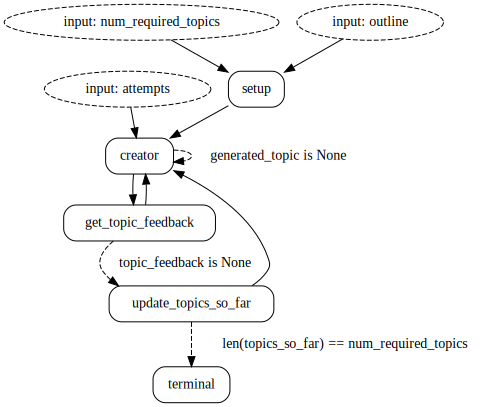

In [5]:
app = topics_application()
app.visualize(
    output_file_path="statemachine",
    include_conditions=True,
    include_state=False,
    format="png",
)

Let's go through the visualization:
1. Give the `ouline` string and the `num_required_topics` as inputs to `setup`.
2. `creator` will run in a loop. Generated one topic at a time.
3. If for whatever reason the `generated_topic` is None, this means there was some error even after some retries. In this case, `creator` will be called again.
4. `get_topic_feedback` will be called to get feedback on `generated_topic`.
5. If `topic_feedback` is None, it means that the user is satisfied. `update_topics_so_far` will be called to add the `generated_topic` to the `topics_so_far` list.
6. If the user is not satisfied, `creator` will be called again with the `generated_topic` and `topic_feedback` added to the `chat_history`.


In [6]:
inputs = {"outline": "history, science, math", "num_required_topics": 3}

while True:
    action, result, state = app.run(halt_after=["terminal"], inputs=inputs)
    # let's stop after we have the required number of topics
    if action.name == "terminal":
        break

In [7]:
app.state["topics_so_far"]

[Topic(name='History', subtopics=[Subtopic(name='Ancient Civilizations', concepts=['Analyze Ancient Empires', 'Compare Ancient Religions', 'Trace Historical Trade Routes', 'Study Ancient Writing Systems']), Subtopic(name='Medieval Period', concepts=['Explore Feudalism And Chivalry', 'Analyze The Rise Of Christianity', 'Study The Black Death And Its Impact', 'Examine The Crusades And Their Consequences']), Subtopic(name='Modern History', concepts=['Analyze The Renaissance And Reformation', 'Study The Age Of Exploration And Colonization', 'Examine The Industrial Revolution And Its Impact', 'Explore The World Wars And Their Aftermath'])]),
 Topic(name='Science', subtopics=[Subtopic(name='Biology', concepts=['Identify Cell Structures', 'Explain Photosynthesis', 'Analyze Dna Replication', 'Study Evolution And Adaptation']), Subtopic(name='Chemistry', concepts=['Understand Atomic Structure', 'Balance Chemical Equations', 'Calculate Molar Mass', 'Explore Chemical Reactions']), Subtopic(name='

In [8]:
topic1 = app.state["topics_so_far"][0]
topic1.model_dump()

{'name': 'History',
 'subtopics': [{'name': 'Ancient Civilizations',
   'concepts': ['Analyze Ancient Empires',
    'Compare Ancient Religions',
    'Trace Historical Trade Routes',
    'Study Ancient Writing Systems']},
  {'name': 'Medieval Period',
   'concepts': ['Explore Feudalism And Chivalry',
    'Analyze The Rise Of Christianity',
    'Study The Black Death And Its Impact',
    'Examine The Crusades And Their Consequences']},
  {'name': 'Modern History',
   'concepts': ['Analyze The Renaissance And Reformation',
    'Study The Age Of Exploration And Colonization',
    'Examine The Industrial Revolution And Its Impact',
    'Explore The World Wars And Their Aftermath']}]}

In [9]:
app.state["chat_history"]

[{'role': 'system',
  'content': '"You are a world class course instructor."\nYou\'ll be given a course outline and you have to generate 3 topics.\nFor each topic:\n    1. Generate a 3-5 word topic name that encapsulates the description.\n    2. Generate 2-4 subtopics for the topic. Also 3-5 words each.\n    For each subtopic:\n        Generate 2-4 concepts. Also 3-5 words each. The concepts should be related to the subtopic.\n        Think of concepts as the smallest unit of knowledge that can be taught from the subtopic. And add a verb to the concept to make it actionable.\n        For example:\n            "Calculate Derivatives" instead of "Derivatives".\n            "Identify Finite Sets" instead of "Finite Sets".\n            "Find the y-intercept" instead of "y-intercept".\n    The subtopics and concepts should be in the correct order.'},
 {'role': 'user',
  'content': '<outline>\nhistory, science, math\n</outline>\n\n<num_required_topics>\n3\n</num_required_topics>\n\n<topics_s